In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
import ast
import os
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt

Mounted at /content/drive


#Models definitions

In [ ]:

class CalorieOneHotDataset(Dataset):
    def __init__(self, df, calorie_col='dish_calories', transform=None):
        """
        Args:
            df (pd.DataFrame): DataFrame with columns 'path', 'dish_calories',
                               and one-hot encoded ingredient columns.
            calorie_col (str): Column name for the calorie target.
            transform: Image transformations to apply.
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.calorie_col = calorie_col

        self.ingredient_cols = [col for col in df.columns if col not in ['path', calorie_col]]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['path']

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Get one-hot encoded ingredient vector as a tensor
        ingredients_vector = row[self.ingredient_cols].values.astype(np.float32)
        ingredients_vector = torch.tensor(ingredients_vector, dtype=torch.float)

        calories = torch.tensor(row[self.calorie_col], dtype=torch.float)

        return image, ingredients_vector, calories

class CaloriePredictorOneHot(nn.Module):
    def __init__(self, ingredient_dim, hidden_dim=128):
        """
        Args:
            ingredient_dim (int): Dimension of the one-hot ingredient vector.
            hidden_dim (int): Number of hidden units in the final FC block.
        """
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()

        self.ingredient_fc = nn.Sequential(
            nn.Linear(ingredient_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        combined_dim = num_features + 32
        self.fc = nn.Sequential(
            nn.Linear(combined_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image, ingredient_vector):
        img_feat = self.resnet(image)
        ingr_feat = self.ingredient_fc(ingredient_vector)
        combined = torch.cat([img_feat, ingr_feat], dim=1)
        out = self.fc(combined)
        return out.squeeze(1)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Definition of our full efficient+resnet model

# ResNet + Attention

In [ ]:

#####################################
# 1. Custom Dataset
#####################################
class FoodCaloriesDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Args:
            df (pd.DataFrame): Must contain 'path' and 'dish_calories' columns.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['path']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Convert dish_calories to a float tensor.
        label = torch.tensor(row['dish_calories'], dtype=torch.float)
        return image, label

#####################################
# 2. Transforms
#####################################
# Standard ImageNet normalization parameters.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Resize images to 224x224, the typical size for ResNet.
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

#####################################
# 3. CBAM (Convolutional Block Attention Module)
#####################################
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        out = x * self.channel_attention(x)
        out = out * self.spatial_attention(out)
        return out

#####################################
# 4. ResNet with CBAM for Calorie Regression
#####################################
class ResNetAttentionCalorieRegressor(nn.Module):
    """
    A ResNet50-based network enhanced with CBAM attention layers.
    The network:
      - Uses a pretrained ResNet50 backbone (up to the last conv layer).
      - Applies CBAM attention to refine the extracted feature maps.
      - Pools the features and passes them through a custom fully connected head.
      - Outputs a single value for calorie regression.
    """
    def __init__(self, pretrained=True):
        super(ResNetAttentionCalorieRegressor, self).__init__()
        # Load a pretrained ResNet50 and remove the average pooling and fc layers.
        resnet = models.resnet50(pretrained=pretrained)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # output shape: (B, 2048, H, W)

        # Add CBAM attention after the backbone.
        self.cbam = CBAM(in_channels=2048, reduction=16, kernel_size=7)

        # Global average pooling to convert (B, 2048, H, W) to (B, 2048, 1, 1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Custom fully connected head.
        self.fc_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.cbam(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        out = self.fc_head(x)
        return out


# define the pipeline model

In [ ]:
class PipelineModelOneHot(nn.Module):
    """
    A pipeline that:
      1) Takes an image and uses `efficient_model` to predict ingredient probabilities.
      2) Converts predicted probabilities to a one-hot vector using a threshold.
      3) Passes the image and the one-hot ingredient vector to `onehot_model` to predict calories.
    """
    def __init__(self, efficient_model, onehot_model, threshold=0.5):
        """
        Args:
            efficient_model (nn.Module): Trained model that predicts multi-label ingredients from an image.
            onehot_model (nn.Module): Calorie predictor model that takes (image, one-hot encoded ingredient vector) and outputs calories.
            threshold (float): Probability threshold to decide if an ingredient is present.
        """
        super().__init__()
        self.efficient_model = efficient_model
        self.onehot_model = onehot_model
        self.threshold = threshold

    def forward(self, images):
        ingredient_logits = self.efficient_model(images)
        ingredient_probs = torch.sigmoid(ingredient_logits)

        ingredient_onehot = (ingredient_probs > self.threshold).float()

        predicted_calories = self.onehot_model(images, ingredient_onehot)
        if predicted_calories.ndim == 2 and predicted_calories.size(1) == 1:
            predicted_calories = predicted_calories.squeeze(1)
        return predicted_calories


# Inception 3v authors resotration

In [ ]:
# Load the pretrained Inception V3
model = models.inception_v3(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model.aux_logits = False


#####################################
# 1. Custom Dataset
#####################################
class FoodCaloriesDataset(Dataset):
    def __init__(self, df, transform=None):

        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['path']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(row['dish_calories'], dtype=torch.float)

        return image, label



mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((299, 299)),      # for Inception V3
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


#####################################
# 3. Enhanced Inception Model
#####################################
class InceptionCalorieRegressor(nn.Module):
    """
    An InceptionV3-based model that:
      - Takes an image input
      - Extracts features with the pretrained InceptionV3 body
      - Passes those features through multiple FC layers
      - Outputs a single numeric value (calories)
    """
    def __init__(self, pretrained=True):
        super(InceptionCalorieRegressor, self).__init__()
        inception = models.inception_v3(pretrained=pretrained)
        inception.aux_logits = False
        in_features = inception.fc.in_features
        inception.fc = nn.Identity()
        self.inception_body = inception
        # multi-layer FC head
        self.fc_head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(128, 1)  # Single output for calorie regression
        )

    def forward(self, x):
        features = self.inception_body(x)  # shape: (batch_size, in_features)
        out = self.fc_head(features)
        return out




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 189MB/s] 


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Deep Final Work/Training dfs/one_hot_test_df.csv')
test_dataset = CalorieOneHotDataset(test_df, transform=transform)
one_hot_test_df = pd.read_csv('/content/drive/MyDrive/Deep Final Work/Training dfs/one_hot_test_df.csv')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
onehot_model = torch.load("/content/drive/MyDrive/Deep Final Work/Saved Models/calorie_predictor_resnet_onehot.pth", map_location=device)
inception_v3_model = torch.load("/content/drive/MyDrive/Deep Final Work/Saved Models/GOOGLES_MODEL_RESORATION.pt", map_location=device)
resnet_attention = torch.load("/content/drive/MyDrive/Deep Final Work/Saved Models/resnet_attention_calorie_regressor.pth", map_location=device)

<ipython-input-10-31d11c04968b>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  onehot_model = torch.load("/content/drive/MyDrive/Deep Final Work/Saved Models/calorie_predi

In [ ]:
efficient_b3_model = models.efficientnet_b3(weights="IMAGENET1K_V1")
num_features = efficient_b3_model.classifier[1].in_features
num_ingredients = 198
efficient_b3_model.classifier[1] = nn.Linear(num_features, num_ingredients)
efficient_b3_model = efficient_b3_model#.to(device)
state_dict = torch.load("/content/drive/MyDrive/Deep Final Work/Saved Models/efficient_3_one_hot.pth", map_location=device)
efficient_b3_model.load_state_dict(state_dict)
efficient_b3_model.to(device)

pipeline_model = PipelineModelOneHot(
    efficient_model=efficient_b3_model,
    onehot_model=onehot_model,
    threshold=0.5
).to(device)
pipeline_model.eval()


<ipython-input-12-73c0771e9dab>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/content/drive/MyDrive/Deep Final Work/Saved Models/efficient_3_one

PipelineModelOneHot(
  (efficient_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
    

In [ ]:
efficient_b3_model = models.efficientnet_b3(weights="IMAGENET1K_V1")
num_features = efficient_b3_model.classifier[1].in_features
num_ingredients = 198
efficient_b3_model.classifier[1] = nn.Linear(num_features, num_ingredients)
efficient_b3_model = efficient_b3_model#.to(device)
state_dict = torch.load("/content/drive/MyDrive/Deep Final Work/Saved Models/efficient_3_one_hot.pth", map_location=device)
efficient_b3_model.load_state_dict(state_dict)
efficient_b3_model.to(device)

pipeline_model = PipelineModelOneHot(
    efficient_model=efficient_b3_model,
    onehot_model=onehot_model,
    threshold=0.5
).to(device)
pipeline_model.eval()


In [ ]:
''' Count the number of degrees of freedom in pipline and resnet with attentino models
'''
# Initialize the model
model = onehot_model
# Count the number of trainable parameters (degrees of freedom)
dof = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Degrees of Freedom (Trainable Parameters) in pipline model: {dof}")
# Initialize the model
model = resnet_attention
# Count the number of trainable parameters (degrees of freedom)
dof = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Degrees of Freedom (Trainable Parameters) in ResNet with attention: {dof}")

Degrees of Freedom (Trainable Parameters) in pipline model: 11261217
Degrees of Freedom (Trainable Parameters) in ResNet with attention: 25147299


#Evaluate the three final models. :
# 1. our final model
#2. inception2 model - based on google paper
#3. some resnet+attention model

# Evaluation

In [ ]:
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.cpu().permute(1, 2, 0).numpy()
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# Part 1: Evaluate 5 Random Images
# -------------------------------
num_samples = 10
sample_indices = random.sample(range(len(test_dataset)), num_samples)

print("Evaluating 5 random samples:")

for idx in sample_indices:
    path = test_dataset.df.iloc[idx]["path"]

    image, ingr_embedding, true_calories = test_dataset[idx]
    true_val = true_calories.item() if isinstance(true_calories, torch.Tensor) else true_calories

    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        pred_pipeline = pipeline_model(image_input)
        pred_inception = inception_v3_model(image_input)
        pred_resnet = resnet_attention(image_input)

    pred_pipeline_val = pred_pipeline.item()
    pred_inception_val = pred_inception.item()
    pred_resnet_val = pred_resnet.item()

    def calc_error(pred, true):
        return 0 if true == 0 else abs(pred - true) / true * 100

    error_pipeline = calc_error(pred_pipeline_val, true_val)
    error_inception = calc_error(pred_inception_val, true_val)
    error_resnet = calc_error(pred_resnet_val, true_val)

    image_disp = denormalize(image)
    plt.figure(figsize=(6, 4))
    plt.imshow(image_disp)
    plt.title(f"Path: {path}\n"
              f"True Calories: {true_val:.2f}\n"
              f"Pipeline: {pred_pipeline_val:.2f} ({error_pipeline:.1f}% error)\n"
              f"InceptionV3: {pred_inception_val:.2f} ({error_inception:.1f}% error)\n"
              f"ResNet-Attention: {pred_resnet_val:.2f} ({error_resnet:.1f}% error)")
    plt.axis("off")
    plt.show()


NameError: name 'torch' is not defined

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize error accumulators.
total_abs_pipeline = 0.0
total_abs_inception = 0.0
total_abs_resnet = 0.0
total_perc_pipeline = 0.0
total_perc_inception = 0.0
total_perc_resnet = 0.0
total_samples = 0

with torch.no_grad():
    for images, ingr_embedding, calories in test_loader:
        images = images.to(device)
        calories = calories.to(device)

        # Predict using each model.
        pred_pipeline = pipeline_model(images)
        pred_inception = inception_v3_model(images)
        pred_resnet = resnet_attention(images)

        # If outputs have shape [batch, 1], squeeze them.
        if pred_pipeline.ndim == 2 and pred_pipeline.size(1) == 1:
            pred_pipeline = pred_pipeline.squeeze(1)
        if pred_inception.ndim == 2 and pred_inception.size(1) == 1:
            pred_inception = pred_inception.squeeze(1)
        if pred_resnet.ndim == 2 and pred_resnet.size(1) == 1:
            pred_resnet = pred_resnet.squeeze(1)

        # Compute absolute error.
        abs_err_pipeline = torch.abs(pred_pipeline - calories)
        abs_err_inception = torch.abs(pred_inception - calories)
        abs_err_resnet = torch.abs(pred_resnet - calories)

        # Compute percentage error for each sample.
        perc_err_pipeline = abs_err_pipeline / torch.clamp(calories, min=1e-8) * 100
        perc_err_inception = abs_err_inception / torch.clamp(calories, min=1e-8) * 100
        perc_err_resnet = abs_err_resnet / torch.clamp(calories, min=1e-8) * 100

        total_abs_pipeline += torch.sum(abs_err_pipeline).item()
        total_abs_inception += torch.sum(abs_err_inception).item()
        total_abs_resnet += torch.sum(abs_err_resnet).item()

        total_perc_pipeline += torch.sum(perc_err_pipeline).item()
        total_perc_inception += torch.sum(perc_err_inception).item()
        total_perc_resnet += torch.sum(perc_err_resnet).item()

        total_samples += images.size(0)

mae_pipeline = total_abs_pipeline / total_samples
mae_inception = total_abs_inception / total_samples
mae_resnet = total_abs_resnet / total_samples

mape_pipeline = total_perc_pipeline / total_samples
mape_inception = total_perc_inception / total_samples
mape_resnet = total_perc_resnet / total_samples

print("Overall Test Set Evaluation:")
print(f"Pipeline Model: MAE = {mae_pipeline:.2f} calories, MAPE = {mape_pipeline:.2f}%")
print(f"InceptionV3 Model: MAE = {mae_inception:.2f} calories, MAPE = {mape_inception:.2f}%")
print(f"ResNet-Attention Model: MAE = {mae_resnet:.2f} calories, MAPE = {mape_resnet:.2f}%")

# Determine which model has the lowest MAPE.
mape_values = {"Pipeline": mape_pipeline, "InceptionV3": mape_inception, "ResNet-Attention": mape_resnet}
best_model = min(mape_values, key=mape_values.get)
print(f"Model with the lowest MAPE: {best_model} (MAPE = {mape_values[best_model]:.2f}%)")


Overall Test Set Evaluation:
Pipeline Model: MAE = 47.98 calories, MAPE = 48.69%
InceptionV3 Model: MAE = 82.21 calories, MAPE = 116.84%
ResNet-Attention Model: MAE = 42.21 calories, MAPE = 39.04%
Model with the lowest MAPE: ResNet-Attention (MAPE = 39.04%)


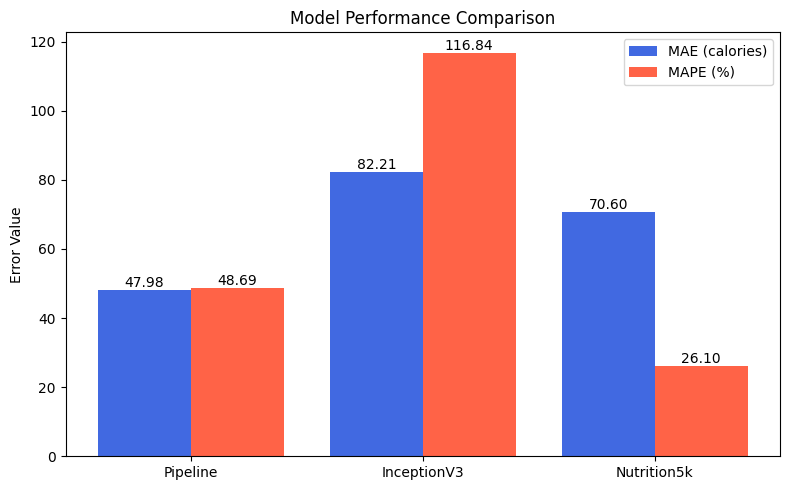

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Partial Results
models = ["Pipeline", "InceptionV3", "Nutrition5k"]
mae_values = [47.98, 82.21, 70.6]
mape_values = [48.69, 116.84, 26.1]

fig, ax1 = plt.subplots(figsize=(8, 5))

# Bar width
bar_width = 0.4
x = np.arange(len(models))

# Plot bars
bars1 = ax1.bar(x - bar_width/2, mae_values, bar_width, label="MAE (calories)", color="royalblue")
bars2 = ax1.bar(x + bar_width/2, mape_values, bar_width, label="MAPE (%)", color="tomato")

# Labels and title
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_ylabel("Error Value")
ax1.set_title("Model Performance Comparison")
ax1.legend()


# Show values on bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


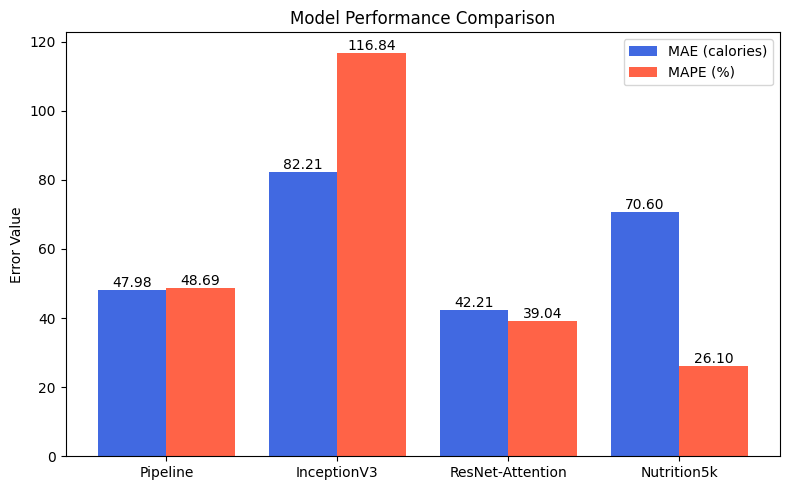

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ALL RESULTS
models = ["Pipeline", "InceptionV3", "ResNet-Attention", "Nutrition5k"]
mae_values = [47.98, 82.21, 42.21, 70.6]
mape_values = [48.69, 116.84, 39.04, 26.1]

fig, ax1 = plt.subplots(figsize=(8, 5))

bar_width = 0.4
x = np.arange(len(models))

bars1 = ax1.bar(x - bar_width/2, mae_values, bar_width, label="MAE (calories)", color="royalblue")
bars2 = ax1.bar(x + bar_width/2, mape_values, bar_width, label="MAPE (%)", color="tomato")

# Labels and title
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_ylabel("Error Value")
ax1.set_title("Model Performance Comparison")
ax1.legend()


# Show values on bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
